<a href="https://colab.research.google.com/github/sebagit914/Challenge01/blob/master/11_7_ExerciseAboutNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [ ]:
# Obtener datos
aapl = pd.read_csv('/content/drive/MyDrive/PTDataScience/PandasForDataManipulation/AAPL.csv', index_col = 'Date')
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,17.065252,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.849854,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.380503,594333600
2013-01-07,18.642857,18.903572,18.400000,18.710714,16.284145,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761072,16.327978,458707200


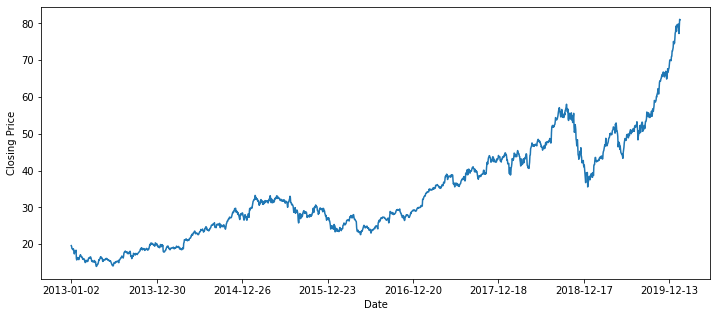

In [ ]:
plt.figure(figsize = (12, 5))
aapl['Close'].plot()
plt.ylabel('Closing Price');

In [ ]:
# Dividir los datos en entrenamiento y pruebas: el de prueba es el mes de enero de 2020
# También usaremos solo la columna cierre
train = np.array(aapl.loc['2013-01-02':'2019-12-31', 'Close'])
test = np.array(aapl.loc['2020-01-01':'2020-01-31', 'Close'])

Escalar datos

Como de costumbre, ya que estamos usando redes neuronales, tenemos que escalar los datos . En este caso, vamos a usar MinMaxScaler para escalar los datos en 0 y 1.

In [ ]:
# Escalar datos entre 0 y 1
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

Reformar datos

Ahora necesitamos reformar nuestros datos. En RNR, usamos una marca de tiempo previa para predecir los próximos valores. Para este ejemplo, vamos a usar los 60 días previos del precio de cierre para predecir el precio de cierre del día siguiente. Para hacer esto, vamos a guardar el valor de las acciones de los 60 días anteriores para nuestro conjunto de variables.

Además, necesitamos que los datos sean tridimensionales para pasarlos a través de la capa RNR (vamos a ocupar una capa LSTM para el ejemplo). La primera dimensión es el número de filas, la segunda es el número de pasos en el tiempo (días) que estamos usando para predecir el precio del día siguiente y, la tercera, es el número de variables. Para este ejemplo, nuestra dimensión tiene que ser (1702, 60, 1), ya que los datos de entrenamiento tienen 1702 filas, estamos ocupando los últimos 60 días para predecir el día siguiente y solo ocupamos el precio de cierre.

El siguiente código cumple con esto. De forma alternativa, puedes usar TimeseriesGeneator en Keras. Puedes ver un ejemplo de esta técnica aquí.

In [ ]:
# Reformar datos
train_features = []
days = []
for i in range(60, train.shape[0]):
    train_features.append(train[i-60:i, 0])
    days.append(train[i, 0])

In [ ]:
# convertir a matrices y remodelar
train_features, days = np.array(train_features), np.array(days)
train_features = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)

In [ ]:
# Paso 1: Definir nuestra estructura de red
# Guardar la forma de entrada
input_shape = train_features.shape[1:3]
input_shape

(60, 1)

In [ ]:
# Modelo secuencial
model = Sequential()

¡Ahora podemos agregar nuestras capas ocultas! Vamos a usar 3 capas LSTM en esta red.

Ya que estamos haciendo una regresión, usaremos la función de activación linear en la capa de salida.

In [ ]:
# Capa LSTM
model.add(LSTM(units = 50, 
               return_sequences = True, # True si la siguiente capa será una capa recurrente
               input_shape = input_shape))
model.add(LSTM(units = 50, 
               return_sequences = True))
model.add(LSTM(units = 50, 
               return_sequences = False))
# Capa de salida
model.add(Dense(units = 1, activation = 'linear'))

Paso 2: Compilar el modelo

Ya que este es un problema de regresión, usaremos el error cuadrático medio como función de pérdida.

In [ ]:
# Paso 2: compilar
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
# Paso 3: ajustar nuestro modelo
history = model.fit(train_features, days, 
                    epochs=100)

Epoch 1/100
54/54 [==============================] - 9s 79ms/step - loss: 0.0111
Epoch 2/100
54/54 [==============================] - 4s 82ms/step - loss: 8.3983e-04
Epoch 3/100
54/54 [==============================] - 4s 81ms/step - loss: 8.0810e-04
Epoch 4/100
54/54 [==============================] - 4s 80ms/step - loss: 7.9911e-04
Epoch 5/100
54/54 [==============================] - 4s 83ms/step - loss: 6.5616e-04
Epoch 6/100
54/54 [==============================] - 4s 82ms/step - loss: 6.4522e-04
Epoch 7/100
54/54 [==============================] - 4s 82ms/step - loss: 5.5953e-04
Epoch 8/100
54/54 [==============================] - 4s 82ms/step - loss: 7.1688e-04
Epoch 9/100
54/54 [==============================] - 4s 82ms/step - loss: 5.1981e-04
Epoch 10/100
54/54 [==============================] - 4s 83ms/step - loss: 5.5697e-04
Epoch 11/100
54/54 [==============================] - 4s 80ms/step - loss: 4.6933e-04
Epoch 12/100
54/54 [==============================] - 4s 82ms/step 

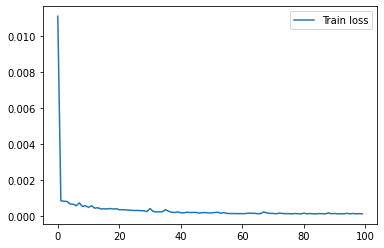

In [ ]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

Predigamos los precios de cierre del mes de enero de 2020 usando los precios de cierre de los 60 días previos. Para poder hacer esto, tenemos que hacer el mismo preprocesamiento que hicimos a los datos de entrenamiento a los datos de prueba.

También tenemos que concatenar los conjuntos de entrenamiento y prueba para usar los 60 pasos en el tiempo previos.

In [ ]:
full = np.concatenate((train, test))

Necesitamos obtener los 60 días previos a enero de 2020 para usarlos en la predicción. También tenemos que reformar los datos de entrenamiento de la misma forma que lo hicimos con los datos de prueba.

In [ ]:
test_days = pd.DataFrame(full)[len(full) - len(test) - 60:].values
# Obtener60 días anteriores para usarlos como funciones
test_features = []
for i in range(60, 80):
    test_features.append(test_days[i-60:i, 0])
# Reformar
test_features = np.array(test_features)
test_features = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

Podemos guardar las predicciones en el conjunto de prueba:

In [ ]:
preds = model.predict(test_features)

Ahora, visualicemos las predicciones del modelo comparadas a los precios de cierre reales de las acciones de Apple para el mes de enero de 2020:

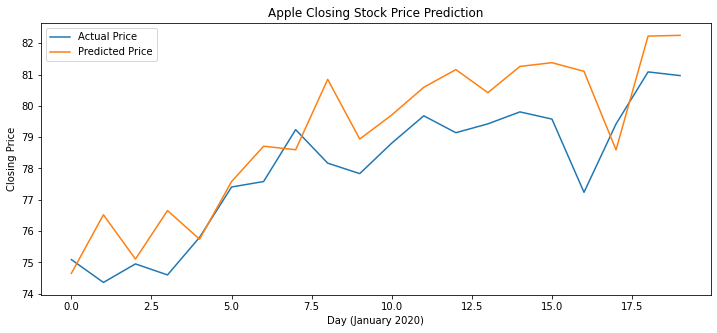

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
plt.plot(scaler.inverse_transform(preds), label='Predicted Price')
plt.title('Apple Closing Stock Price Prediction')
plt.xlabel('Day (January 2020)')
plt.ylabel('Closing Price')
plt.legend();

Aunque no es perfecto, nuestro modelo hace un buen trabajo al predecir los precios de las acciones para el día siguiente, usando precios de cierre de los 60 días previos.